In [57]:
import numpy as np
import pandas as pd
import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
from datetime import datetime,date

%matplotlib inline
init_notebook_mode(connected=True)
cf.set_config_file(sharing='private',theme='pearl',offline=True)
#print("Cufflinks Version : {}".format(cf.__version__))

df = pd.read_csv('./data/btc-usd-max.csv',index_col=0,parse_dates=True )
df = df.resample('D').first()
df['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])
df2 = pd.read_csv('./data/eth-usd-max.csv',index_col=0,parse_dates=True )
df2 = df2.resample('D').first()
df2['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])

In [64]:
def first_day(entry):
    """
    Returns the first instance of the period, regardless of sampling rate.
    """
    if len(entry):  # handles the case of missing data
        return entry[0]

In [81]:
# here i will use monthly data
df2= df2.resample(rule='MS').apply(first_day)

In [83]:
df2.index

DatetimeIndex(['2015-08-01 00:00:00+00:00', '2015-09-01 00:00:00+00:00',
               '2015-10-01 00:00:00+00:00', '2015-11-01 00:00:00+00:00',
               '2015-12-01 00:00:00+00:00', '2016-01-01 00:00:00+00:00',
               '2016-02-01 00:00:00+00:00', '2016-03-01 00:00:00+00:00',
               '2016-04-01 00:00:00+00:00', '2016-05-01 00:00:00+00:00',
               '2016-06-01 00:00:00+00:00', '2016-07-01 00:00:00+00:00',
               '2016-08-01 00:00:00+00:00', '2016-09-01 00:00:00+00:00',
               '2016-10-01 00:00:00+00:00', '2016-11-01 00:00:00+00:00',
               '2016-12-01 00:00:00+00:00', '2017-01-01 00:00:00+00:00',
               '2017-02-01 00:00:00+00:00', '2017-03-01 00:00:00+00:00',
               '2017-04-01 00:00:00+00:00', '2017-05-01 00:00:00+00:00',
               '2017-06-01 00:00:00+00:00', '2017-07-01 00:00:00+00:00',
               '2017-08-01 00:00:00+00:00', '2017-09-01 00:00:00+00:00',
               '2017-10-01 00:00:00+00:00', '2017-1

In [84]:
df2['price'].iplot()

In [85]:
df2['price'].iplot(logy=True)

In [86]:
## perform a dickey-fuller test for seasonality on BTC
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [87]:
adf_test(df2['price'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.942545
p-value                  0.312319
# lags used             11.000000
# observations          74.000000
critical value (1%)     -3.521980
critical value (5%)     -2.901470
critical value (10%)    -2.588072
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


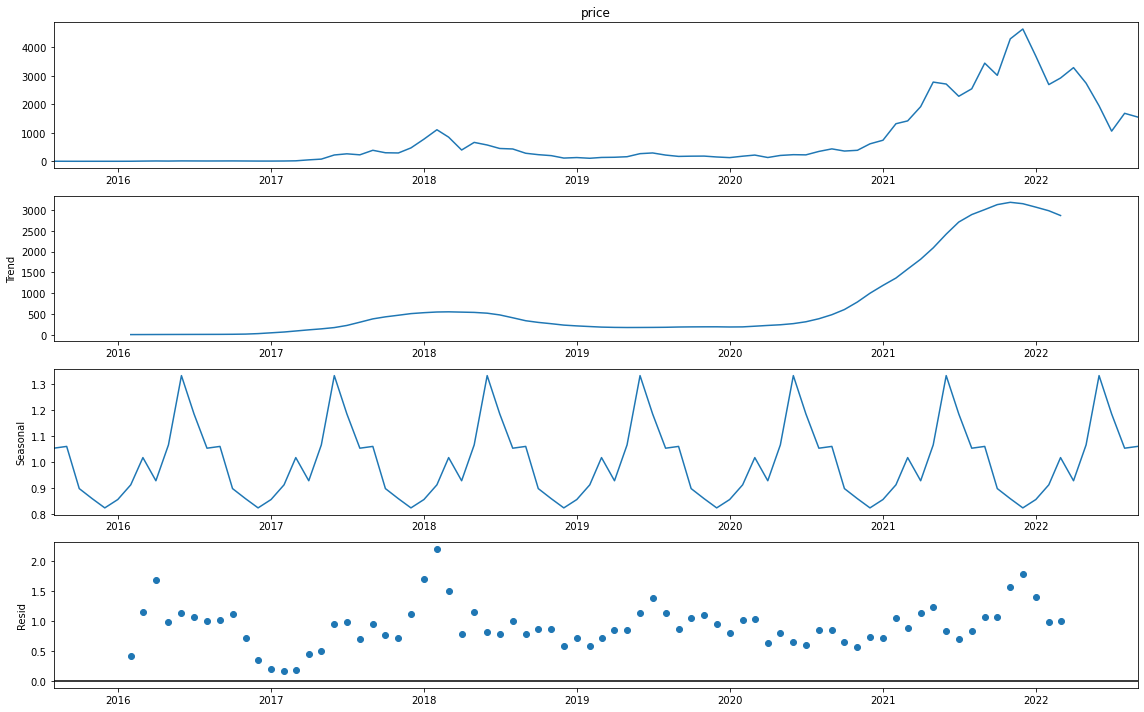

In [88]:
# perform an ETS decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2['price'], model='multiplicative')  # model='mul' also works
from pylab import rcParams
rcParams['figure.figsize']= 16,10
result.plot();

In [89]:
# use auto arima to find possible p, d, q values
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [127]:
# run auto_arima to evaluate p,d and q with defauls parameters. Here we use seasonal=True to have the seasonal part
# of Sarima plus the P,D,Q
auto_arima(df2['price'], seasonal=True, m=12)

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [128]:
# we can derive the above 1,1,1 values manually
# first we see if I so 1 differentiation is enough for the data to be stationary
# as seen above currnet p for dickey fuller is 0.423075 which shows trend and seasonality
# the result we get is a p value close to zero so with 1 differentiation the data become stationary therefore prooving the 
# d =1 from the auto arima above!
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['price'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df2['d1'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic      -3.493664
p-value                  0.008151
# lags used             12.000000
# observations          72.000000
critical value (1%)     -3.524624
critical value (5%)     -2.902607
critical value (10%)    -2.588679
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


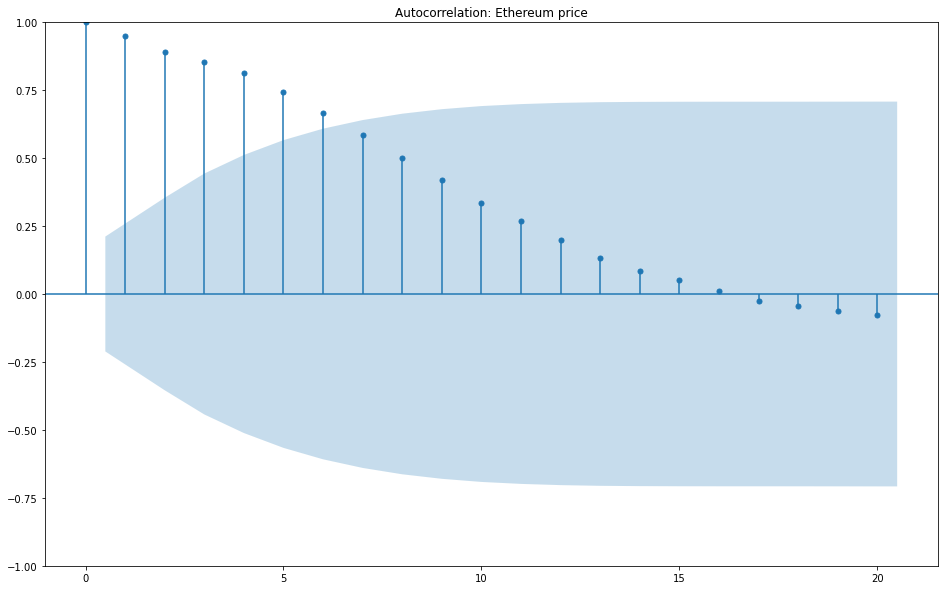

In [129]:
# now in order to see the p and d values we will plot the acf and pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
title = 'Autocorrelation: Ethereum price'
lags = 20
plot_acf(df2['price'],title=title,lags=lags);

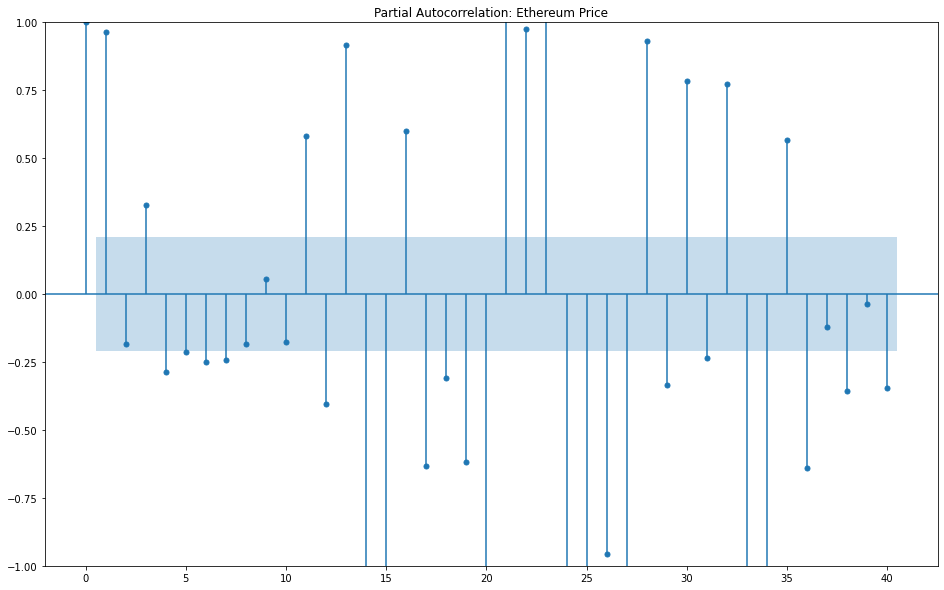

In [130]:
title = 'Partial Autocorrelation: Ethereum Price'
lags = 40
plot_pacf(df2['price'],title=title,lags=lags);

In [131]:
# from the above and looking at vaious interpretation maulas online, The AR term can be determined by the PACF
# chart at the point where there is a stip drop so we start at 0 lag , then 1 and so on. the lag the valu falls a lot
# is conisdered the p value for AR. then we check both the ACF and the PACF. if the ACF is not stip then depending on 
# the AR found before we can either day q = 0 or 1 so we try bouth and evaluate the results. 
# https://people.duke.edu/~rnau/411arim3.htm

In [132]:
# now we will try more advanced auto arima evaluation for the SARIMA parameters
stepwise_fit = auto_arima(df2['price'], start_p=0, start_q=0,
                          max_p=5, max_q=5, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1231.837, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1234.638, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1233.649, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1230.093, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1233.614, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1233.606, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1232.761, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1231.799, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1229.661, Time=0.18 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1231.408, Time=0.32 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1231.408, Time=0.27 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1233.333, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1231.093, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   86
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -610.867
Date:                Sat, 24 Sep 2022   AIC                           1227.734
Time:                        18:07:57   BIC                           1235.062
Sample:                    08-01-2015   HQIC                          1230.681
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1460      0.065      2.252      0.024       0.019       0.273
ar.L2         -0.2469      0.063     -3.912      0.000      -0.371      -0.123
sigma2      1.021e+05   8988.264     11.362      0.000    8.45e+04     1.2e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               174.04
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):              83.51   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [133]:
len(df2)

86

In [134]:
# Set one year for testing
train = df2.iloc[:-12]
test = df2.iloc[-12:]

In [135]:
# create an ARIMA Model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['price'],order=(2,1,0),seasonal_order=(0,0,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   74
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -488.165
Date:                Sat, 24 Sep 2022   AIC                            982.331
Time:                        18:08:10   BIC                            989.202
Sample:                    08-01-2015   HQIC                           985.069
                         - 09-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3968      0.078      5.062      0.000       0.243       0.550
ar.L2         -0.3099      0.068     -4.588      0.000      -0.442      -0.178
sigma2      3.752e+04   3857.364      9.727      0.000       3e+04    4.51e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                79.31
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):              90.91   Skew:                             1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
# Obtain predicted values
# CAUTION ON typ='levels'! the default is linear but in an arima model if we select linear it will predict
# based the differnced - so the stationary data and not the initial data which is what we want!!!
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2,1,0) (0,0,0,12) Predictions')

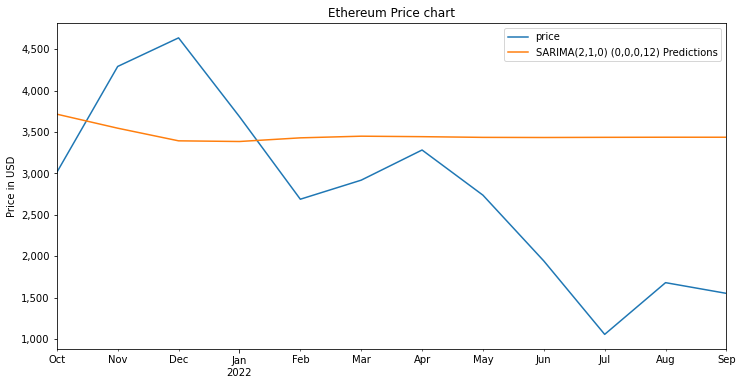

In [137]:
# Plot predictions against known values
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Ethereum Price chart'
ylabel='Price in USD'
xlabel='' # we don't really need a label here

ax = test['price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [138]:
# evaluating the model
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['price'], predictions)
print(f'ARIMA(1,1,1) MSE Error: {error:11.10}')

ARIMA(1,1,1) MSE Error: 1545171.826


In [139]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['price'], predictions)
print(f'ARIMA(1,1,1) RMSE Error: {error:11.10}')

ARIMA(1,1,1) RMSE Error: 1243.049406


In [140]:
# Retrain the model on the full data, and forecast the future
model = ARIMA(df2['price'],order=(1,1,1))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+12,typ='levels').rename('ARIMA(1,1,1) Forecast')

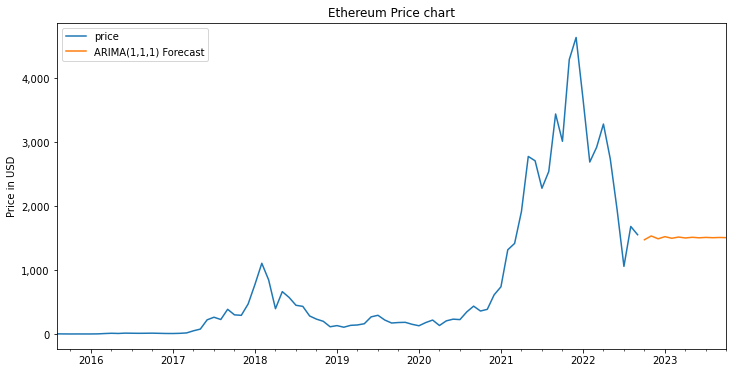

In [141]:
# Plot predictions against known values
title = 'Ethereum Price chart'
ylabel='Price in USD'
xlabel='' # we don't really need a label here

ax = df2['price'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [142]:
# same plot as above but with plotly
result = df2.join(fcast, how='outer')
result[['price','ARIMA(1,1,1) Forecast']].iplot()